In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [ ]:
# Run some setup code for this notebook.

import random
import numpy as np
import matplotlib.pyplot as plt
from cs231n.data_utils import load_CIFAR10
import importlib, sys

# If using CS231n code, make sure the path is set correctly:
# from cs231n.data_utils import load_CIFAR10

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# --- Fix for Python 3.12 autoreload issue ---
# Patch "imp" module so autoreload still works
if "imp" not in sys.modules:
    import types
    imp = types.ModuleType("imp")
    imp.reload = importlib.reload
    sys.modules["imp"] = imp

# Enable autoreload so external python modules are reloaded automatically
%reload_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [ ]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [ ]:
from cs231n.features import *

# num_color_bins = 10 # Number of bins in the color histogram
num_color_bins = 25 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train Softmax classifier on features
Using the Softmax code developed earlier in the assignment, train Softmax classifiers on top of the features extracted above; this should achieve better results than training them directly on top of raw pixels.

In [ ]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import Softmax

learning_rates = [1e-7, 5e-7, 1e-6, 5e-6, 1e-5]
regularization_strengths = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5]

results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the Softmax; save#
# the best trained classifer in best_softmax. If you carefully tune the model, #
# you should be able to get accuracy of above 0.42 on the validation set.      #
################################################################################

for lr in learning_rates:
    for reg in regularization_strengths:
        # Create and train a new Softmax classifier
        softmax = Softmax()
        softmax.train(
            X_train_feats, y_train,
            learning_rate=lr,
            reg=reg,
            num_iters=2000,     # can increase if underfitting
            batch_size=200,
            verbose=False
        )

        # Evaluate on training and validation sets
        y_train_pred = softmax.predict(X_train_feats)
        train_accuracy = np.mean(y_train == y_train_pred)

        y_val_pred = softmax.predict(X_val_feats)
        val_accuracy = np.mean(y_val == y_val_pred)

        # Store results
        results[(lr, reg)] = (train_accuracy, val_accuracy)

        # Track best model
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax

        print(f"lr {lr:.1e} reg {reg:.1e} train acc {train_accuracy:.3f} val acc {val_accuracy:.3f}")

print('best validation accuracy achieved: %f' % best_val)

lr 1.0e-07 reg 2.5e+04 train acc 0.422 val acc 0.421
lr 1.0e-07 reg 5.0e+04 train acc 0.422 val acc 0.420
lr 1.0e-07 reg 7.5e+04 train acc 0.423 val acc 0.429
lr 1.0e-07 reg 1.0e+05 train acc 0.420 val acc 0.420
lr 1.0e-07 reg 2.5e+05 train acc 0.416 val acc 0.412
lr 5.0e-07 reg 2.5e+04 train acc 0.422 val acc 0.406
lr 5.0e-07 reg 5.0e+04 train acc 0.420 val acc 0.425
lr 5.0e-07 reg 7.5e+04 train acc 0.420 val acc 0.412
lr 5.0e-07 reg 1.0e+05 train acc 0.418 val acc 0.420
lr 5.0e-07 reg 2.5e+05 train acc 0.401 val acc 0.400
lr 1.0e-06 reg 2.5e+04 train acc 0.421 val acc 0.416
lr 1.0e-06 reg 5.0e+04 train acc 0.408 val acc 0.399
lr 1.0e-06 reg 7.5e+04 train acc 0.415 val acc 0.415
lr 1.0e-06 reg 1.0e+05 train acc 0.401 val acc 0.403
lr 1.0e-06 reg 2.5e+05 train acc 0.387 val acc 0.406
lr 5.0e-06 reg 2.5e+04 train acc 0.400 val acc 0.412
lr 5.0e-06 reg 5.0e+04 train acc 0.397 val acc 0.408
lr 5.0e-06 reg 7.5e+04 train acc 0.369 val acc 0.375
lr 5.0e-06 reg 1.0e+05 train acc 0.317 val acc

In [ ]:
# Evaluate your trained Softmax on the test set: you should be able to get at least 0.42
y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.416


In [ ]:
# Save best softmax model
best_softmax.save("best_softmax_features.npy")

best_softmax_features.npy saved.


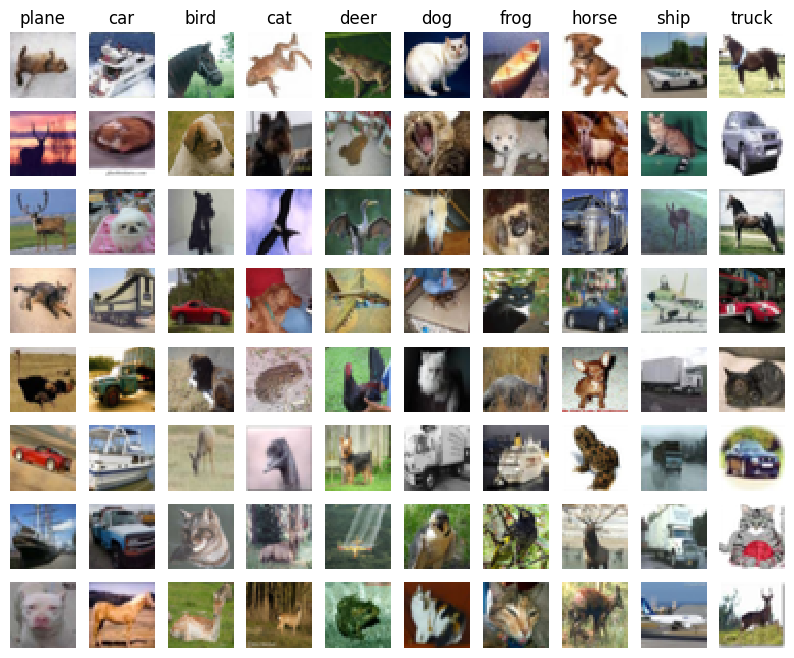

In [ ]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ Vehicles: Cars, trucks, and ships are often confused with each other. A truck might be misclassified as a ship, and vice versa. This likely happens because the model focuses on large, boxy shapes and fails to distinguish finer details.

Animals: The most frequent errors involve animals with similar features. Dogs are often mistaken for cats, and vice versa. This is a very common error due to their shared facial features, fur, and body shapes. Similarly, horses are sometimes confused with deer because both are four-legged herbivores. Birds and planes are also mixed up, likely because from a distance, they can appear as small, dark objects against the sky.

Other: There are some less common but still understandable errors, such as a frog being misclassified as a cat. This could be due to an unusual pose, poor lighting, or a low-resolution image where the frog's silhouette resembles a cat.





## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 170)
(49000, 169)


In [ ]:
print("y_train shape:", y_train.shape, "dtype:", y_train.dtype)
print("y_val shape:", y_val.shape, "dtype:", y_val.dtype)
print("y_test shape:", y_test.shape, "dtype:", y_test.dtype)

print("Unique labels in y_train:", np.unique(y_train)[:10])


y_train shape: (49000,) dtype: int64
y_val shape: (1000,) dtype: int64
y_test shape: (1000,) dtype: int64
Unique labels in y_train: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
net = TwoLayerNet(input_dim, hidden_dim, num_classes)
scores = net.loss(X_train_feats[:5])   # forward only, no labels
print("Scores shape:", scores.shape)


Scores shape: (5, 10)


In [ ]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

data = {
    'X_train': X_train_feats,
    'y_train': y_train,
    'X_val': X_val_feats,
    'y_val': y_val,
    'X_test': X_test_feats,
    'y_test': y_test,
}

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

# Define a set of hyperparameters to try
learning_rates = [1e-3, 5e-3, 1e-2]
regularization_strengths = [1e-4, 5e-4, 1e-3]
hidden_dims = [200, 500]

best_val_acc = 0.0
best_net = None

for hd in hidden_dims:
    for lr in learning_rates:
        for reg in regularization_strengths:
            print(f"Training with hidden_dim={hd}, lr={lr}, reg={reg}")

            # Create a new network with the given hidden dimension
            net = TwoLayerNet(input_dim, hd, num_classes, weight_scale=1e-3, reg=reg)

            # Create the solver
            solver = Solver(
                net,
                data,
                update_rule='sgd',
                optim_config={'learning_rate': lr},
                lr_decay=0.95,
                num_epochs=10,
                batch_size=200,
                print_every=100,
                verbose=False
            )

            solver.train()

            # Evaluate accuracy on the validation set
            val_acc = np.mean(solver.check_accuracy(data['X_val'], data['y_val']))
            print(f"Validation accuracy: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_net = net

print("Best validation accuracy:", best_val_acc)


Training with hidden_dim=200, lr=0.001, reg=0.0001
Validation accuracy: 0.1660
Training with hidden_dim=200, lr=0.001, reg=0.0005
Validation accuracy: 0.1170
Training with hidden_dim=200, lr=0.001, reg=0.001
Validation accuracy: 0.1440
Training with hidden_dim=200, lr=0.005, reg=0.0001
Validation accuracy: 0.2760
Training with hidden_dim=200, lr=0.005, reg=0.0005
Validation accuracy: 0.2610
Training with hidden_dim=200, lr=0.005, reg=0.001
Validation accuracy: 0.2800
Training with hidden_dim=200, lr=0.01, reg=0.0001
Validation accuracy: 0.3390
Training with hidden_dim=200, lr=0.01, reg=0.0005
Validation accuracy: 0.3650
Training with hidden_dim=200, lr=0.01, reg=0.001
Validation accuracy: 0.3660
Training with hidden_dim=500, lr=0.001, reg=0.0001
Validation accuracy: 0.1890
Training with hidden_dim=500, lr=0.001, reg=0.0005
Validation accuracy: 0.2290
Training with hidden_dim=500, lr=0.001, reg=0.001
Validation accuracy: 0.2320
Training with hidden_dim=500, lr=0.005, reg=0.0001
Validati

In [ ]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 58% accuracy. It is also possible to get >60% accuracy
# with careful tuning.

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.372


In [ ]:
# Save best model
best_net.save("best_two_layer_net_features.npy")

best_two_layer_net_features.npy saved.
